# Prediction of Gross

### Loading data set cleaned

In [108]:
%pip install cpi
# Modify into setup and requirements

In [109]:
import os
from urllib.request import urlretrieve

def download_dataset():

    urls = [
        ("1_zkibYlJyj5ZkLulFYtJ4_vp9RtgoUtW",
        "cleaned_film_datset.csv"),
    ]

    for (fileId, filename) in urls:
        urlretrieve(f"https://drive.usercontent.google.com/download?id={fileId}&export=download&authuser=1&confirm=t", f"./{filename}")

download_dataset()

In [110]:
import ast
import cpi
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import tensorflow as tf
from sklearn.feature_selection import RFECV, RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler


In [111]:
movies_df = pd.read_csv("cleaned_film_datset.csv")
movies_df.drop(columns=[
    #'genre_imdb',
    'spoken_languages',
    #'popularity',
    'description_tmdb',
    'adult',
    'Unnamed: 0',
    #'genre_letterboxd',
    'imdb_id',
    'original_language',
    'description_letterboxd',
    'tmdb_id',
    'description_imdb'],
               inplace=True)

In [112]:
pd.set_option('display.max_columns', None)

### Adjustment of features for data vizualization for correlation and adjustment for data  prediction

Making sure it has the right format


In [113]:
movies_df['year']=movies_df['year'].astype(int)
movies_df['runtime']=movies_df['runtime'].astype(int)
movies_df['gross']=movies_df['gross'].astype(int)
movies_df['revenue']=movies_df['revenue'].astype(int)
movies_df['budget']=movies_df['budget'].astype(int)
movies_df['vote_count_letterboxd']=movies_df['vote_count_letterboxd'].astype(int)
movies_df['vote_count_imdb']=movies_df['vote_count_imdb'].astype(int)
movies_df['release_date'] = pd.to_datetime(movies_df['release_date'])
movies_df['popularity']=movies_df['popularity'].astype(int)

Separate information with comas into new columns:


*   Director
*   Stars




In [114]:
def extract_ids(column):
    return column.str.extractall('nm(\d+)/').groupby(level=0).agg(','.join)[0]
movies_df['director'] = movies_df['director'].astype(str).str.replace(r" \n", "", regex=True)
movies_df['director_ids'] = extract_ids(movies_df['director_id'])
movies_df['star'] = movies_df['star'].astype(str).str.replace(r" \n", "", regex=True)
movies_df['star_ids'] = extract_ids(movies_df['star_id'])
movies_df.drop(columns=['star_id','director_id'], inplace=True)

Merge genre instances and eliminate duplicated genres

In [115]:
try:
  # Make genre_letterboxd column has the same format as the other two genre columns
  movies_df['genre_letterboxd'] = movies_df['genre_letterboxd'].astype(str).str.replace(r"[\"\[\]]", "", regex=True)
  # Merge the three genre columns into one general genre column
  movies_df['genre'] = movies_df['genre_letterboxd']+ ', ' + movies_df['genre_tmdb'] + ', ' + movies_df['genre_imdb']
  # Take the genre column values to a standard format by removing spaces and applying lowercase
  movies_df['genre'] = movies_df['genre'].str.lower().str.replace(' ', '')
  # Split the genre column into individual genres, removing the duplicates
  movies_df['genre'] = movies_df['genre'].apply(lambda x: list(set(x.split(','))))
  # Combine unique genres
  movies_df['genre'] = movies_df['genre'].apply(lambda x: ', '.join(x))
  # Drop unnecessary columns
  movies_df.drop(columns=['genre_letterboxd', 'genre_imdb', 'genre_tmdb'], inplace=True)
except:
  print('Genre conditioning already done')

Convert the text string of the production countries column to a Python list

In [116]:
try:
  movies_df['production_countries'] = movies_df['production_countries'].apply(ast.literal_eval)
  max_countries = movies_df['production_countries'].apply(len).max()
  for i in range(max_countries):
      col_name = f'country_{i+1}'
      movies_df[col_name] = movies_df['production_countries'].apply(lambda x: x[i] if i < len(x) else None)
  movies_df = movies_df.drop(columns=[f'country_{i}' for i in range(2, max_countries+1)])
  movies_df.drop('production_countries', axis=1, inplace=True, errors='ignore')
  movies_df.rename(columns={'country_1': 'production_country'}, inplace=True)
except:
  print('Production countries already converted')
movies_df.head()

,title,popularity,release_date,rating_letterboxd,vote_count_letterboxd,year,rating_imdb,director,star,vote_count_imdb,gross,revenue,runtime,budget,production_companies,director_ids,star_ids,genre,production_country
0,The Christine Jorgensen Story,1,1970-10-29,4.2,5,1970,5.5,Irving Rapper,"John Hansen,Joan Tompkins,Quinn K. Redeker,Joh...",373,237000,0,98,0,Edward Small Productions,0710924,"0360896,0867000,0714793,0385402","drama, biography, romance",United States of America
1,Say It Isn't So,7,2001-03-10,4.8,124,2001,5.0,J.B. Rogers,"Chris Klein,Heather Graham,Orlando Jones,Sally...",13462,5516708,12320393,95,25000000,"Say It Isn't So Productions, Conundrum Enterta...",0736930,"0005098,0001287,0428963,0000398","comedy, romance",United States of America
2,Killers,22,2010-06-04,5.9,1819,2010,5.4,Robert Luketic,"Katherine Heigl,Ashton Kutcher,Tom Selleck,Cat...",93114,47059963,98159963,100,75000000,"Katalyst Films, Lionsgate, Aversano Films",0525659,"0001337,0005110,0000633,0001573","action, comedy, thriller, romance",United States of America
3,In the Shadow of Women,2,2015-05-14,6.0,37,2015,6.5,Philippe Garrel,"Clotilde Courau,Stanislas Merhar,Lena Paugam,V...",1496,50291,54985,73,0,"SBS Productions, ARTE France Cinéma, Close Up ...",0308042,"0183660,0580720,6360949,2169779","drama, romance",Switzerland
4,The Pope of Greenwich Village,5,1984-06-22,6.5,91,1984,6.6,Stuart Rosenberg,"Eric Roberts,Mickey Rourke,Daryl Hannah,Gerald...",9212,6139896,6836201,121,8000000,United Artists,0742341,"0000616,0000620,0000435,0656183","action, crime, drama, comedy",United States of America


Lower case of production companies names

In [117]:
movies_df['production_companies'] = movies_df['production_companies'].str.lower()
movies_df['production_companies'] = movies_df['production_companies'].apply(lambda x: list(set(x.split(', '))))
movies_df['production_companies']

0                               [edward small productions]
1        [conundrum entertainment, say it isn't so prod...
2              [aversano films, lionsgate, katalyst films]
3        [rts, close up films, sbs productions, arte fr...
4                                         [united artists]
                               ...                        
11235    [halestorm entertainment, mirror films, blue c...
11236          [radar films, france 2 cinéma, studiocanal]
11237         [mbs, shueisha, dugout, toho, sumzap, mappa]
11238                                    [new line cinema]
11239                              [minerva international]
Name: production_companies, Length: 11240, dtype: object

Get months and season from released dates

In [118]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'
movies_df['season'] = movies_df['release_date'].dt.month.apply(get_season)
movies_df= movies_df.drop('release_date', axis=1)
movies_df.head()

,title,popularity,rating_letterboxd,vote_count_letterboxd,year,rating_imdb,director,star,vote_count_imdb,gross,revenue,runtime,budget,production_companies,director_ids,star_ids,genre,production_country,season
0,The Christine Jorgensen Story,1,4.2,5,1970,5.5,Irving Rapper,"John Hansen,Joan Tompkins,Quinn K. Redeker,Joh...",373,237000,0,98,0,[edward small productions],0710924,"0360896,0867000,0714793,0385402","drama, biography, romance",United States of America,Fall
1,Say It Isn't So,7,4.8,124,2001,5.0,J.B. Rogers,"Chris Klein,Heather Graham,Orlando Jones,Sally...",13462,5516708,12320393,95,25000000,"[conundrum entertainment, say it isn't so prod...",0736930,"0005098,0001287,0428963,0000398","comedy, romance",United States of America,Spring
2,Killers,22,5.9,1819,2010,5.4,Robert Luketic,"Katherine Heigl,Ashton Kutcher,Tom Selleck,Cat...",93114,47059963,98159963,100,75000000,"[aversano films, lionsgate, katalyst films]",0525659,"0001337,0005110,0000633,0001573","action, comedy, thriller, romance",United States of America,Summer
3,In the Shadow of Women,2,6.0,37,2015,6.5,Philippe Garrel,"Clotilde Courau,Stanislas Merhar,Lena Paugam,V...",1496,50291,54985,73,0,"[rts, close up films, sbs productions, arte fr...",0308042,"0183660,0580720,6360949,2169779","drama, romance",Switzerland,Spring
4,The Pope of Greenwich Village,5,6.5,91,1984,6.6,Stuart Rosenberg,"Eric Roberts,Mickey Rourke,Daryl Hannah,Gerald...",9212,6139896,6836201,121,8000000,[united artists],0742341,"0000616,0000620,0000435,0656183","action, crime, drama, comedy",United States of America,Summer


### Vizualization for correlation
*** CHECK THIS PART ***


In [119]:
fig = px.scatter(movies_df, x='budget', y='gross', trendline='ols')
fig.update_layout(title='Budget vs Gross')
fig.show()

In [120]:
fig = px.scatter(movies_df, x='runtime', y='gross', trendline='ols')
fig.update_layout(title='Runtime vs Gross Revenue')
fig.show()

In [121]:
#movies_df[movies_df['gross'] > 200]
fig = px.scatter(movies_df, x='rating_imdb', y='gross', trendline='ols')
fig.update_layout(title='IMDB Rating vs Gross')
fig.show()

In [122]:
fig = px.line(movies_df[['year','gross']].groupby('year').mean().reset_index(), x='year', y='gross')
fig.update_layout(title='Average Gross Over Time')
fig.show()

In [123]:
seasonal_gross = movies_df.groupby(['year', 'season'])['gross'].mean().reset_index()

fig = px.line(seasonal_gross, x='year', y='gross', color='season',
              title='Average Gross for Season trough the years',
              labels={'year': 'Year', 'gross': 'Average Gross'},
              category_orders={"Season": ["Winter", "Spring", "Summer", "Fall"]})

fig.update_layout(xaxis_title='Year', yaxis_title='Average Gross', hovermode='x')

fig.show()

In [124]:
gross_by_director = movies_df.groupby('director')['gross'].sum().reset_index()

top_directors = gross_by_director.sort_values('gross', ascending=False).head(20)

df_top_directors = movies_df[movies_df['director'].isin(top_directors['director'])]

fig = px.scatter(df_top_directors,
                 x='budget',
                 y='gross',
                 color='director',  # Color by director to differentiate them
                 size='gross',  # Use 'gross' as bubble size to highlight top-grossing movies
                 hover_name='director',  #Shows the director's name when you mouse over the bubble
                 title=f'Top {top_directors.shape[0]} Directors by Gross: Gross vs. Budget')

fig.update_layout(xaxis_title='Budget', yaxis_title='Gross', legend_title='Top 20 Directors by Gross')
fig.show()

In [125]:
director_counts = movies_df.groupby('director').agg({'gross': 'sum', 'title': 'count'}).reset_index()

director_counts.columns = ['director', 'total_gross', 'movie_count']

top_directors = director_counts.sort_values('total_gross', ascending=False).head(20)

fig = px.scatter(top_directors,
                 x='movie_count',
                 y='total_gross',
                 size='total_gross',
                 color='director',
                 hover_name='director',
                 title=f'Top {top_directors.shape[0]} Directors: Number of movies vs. Gross Total')

fig.update_layout(xaxis_title='Number of movies', yaxis_title='Gross Total', legend_title='Director')
fig.show()

In [126]:
movies_df.columns
movies_df['director']

0           Irving Rapper
1             J.B. Rogers
2          Robert Luketic
3         Philippe Garrel
4        Stuart Rosenberg
               ...       
11235    Christian Vuissa
11236      Nicolas Vanier
11237       Seong-Hu Park
11238        Carlos Avila
11239         Mac Ahlberg
Name: director, Length: 11240, dtype: object

In [127]:
movies_df[['first_star', 'second_star']] = movies_df['star'].str.split(',', n=2, expand=True)[[0, 1]]
movies_df['second_star'] = movies_df['second_star'].str.replace('\n', '', regex=False)

actor_stats = movies_df.groupby('first_star').agg({'gross': 'sum', 'budget': 'sum', 'title': 'count'}).reset_index()

actor_stats.columns = ['first_star', 'total_gross', 'total_budget', 'movie_count']

top_actors = actor_stats.sort_values('total_gross', ascending=False).head(50)

fig = px.scatter(top_actors,
                 x='total_budget',
                 y='total_gross',
                 size='movie_count',
                 color='first_star',
                 hover_name='first_star',
                 title=f'Top {top_actors.shape[0]} 1- Actors: Gross Total vs. Budget Total')

fig.update_layout(xaxis_title='Budget Total', yaxis_title='Gross Total', legend_title='Actor')

fig.show()

In [129]:
fig = px.scatter(top_actors,
                 x='movie_count',
                 y='total_gross',
                 size='movie_count',
                 color='first_star',
                 hover_name='first_star',
                 title=f'Top {top_actors.shape[0]} 1- Actors: Gross Total vs. Number of Appearances')

fig.update_layout(xaxis_title='Number of Appearances', yaxis_title='Gross Total', legend_title='Actor')
fig.show()

In [130]:


actor_stats = movies_df.groupby('second_star').agg({'gross': 'sum', 'budget': 'sum', 'title': 'count'}).reset_index()

actor_stats.columns = ['star', 'total_gross', 'total_budget', 'movie_count']

top_actors = actor_stats.sort_values('total_gross', ascending=False).head(50)

fig = px.scatter(top_actors,
                 x='total_budget',
                 y='total_gross',
                 size='movie_count',
                 color='star',
                 hover_name='star',
                 title=f'Top {top_actors.shape[0]} 2- Actors: Gross Total vs. Budget Total')

fig.update_layout(xaxis_title='Budget Total', yaxis_title='Gross Total', legend_title='Actor')

fig.show()

In [131]:
fig = px.scatter(top_actors,
                 x='movie_count',
                 y='total_gross',
                 size='movie_count',
                 color='star',
                 hover_name='star',
                 title=f'Top {top_actors.shape[0]} 2- Actors: Gross Total vs. Number of Appearances')

fig.update_layout(xaxis_title='Number of Appearances', yaxis_title='Gross Total', legend_title='Actor')
fig.show()

movies_df.drop(columns=['first_star', 'second_star'], inplace=True)

### Adjust features for data predictions

Add inflation to the data frame

In [132]:
def adjust_for_inflation(amount, year):
    try:
        return cpi.inflate(amount, year)
    except:
        return amount

movies_df['gross_adjusted'] = movies_df.apply(lambda x: adjust_for_inflation(x['gross'], x['year']), axis=1)
movies_df['budget_adjusted'] = movies_df.apply(lambda x: adjust_for_inflation(x['budget'], x['year']), axis=1)
movies_df['revenue_adjusted'] = movies_df.apply(lambda x: adjust_for_inflation(x['revenue'], x['year']), axis=1)

In [133]:
movies_df[['year','budget', 'gross','revenue','budget_adjusted', 'gross_adjusted','revenue_adjusted']].head()

,year,budget,gross,revenue,budget_adjusted,gross_adjusted,revenue_adjusted
0,1970,0,237000,0,0.000000e+00,1.861195e+06,0.000000e+00
1,2001,25000000,5516708,12320393,4.301270e+07,9.491541e+06,2.119734e+07
2,2010,75000000,47059963,98159963,1.048017e+08,6.575955e+07,1.371645e+08
3,2015,0,50291,54985,0.000000e+00,6.465261e+04,7.068708e+04
4,1984,8000000,6139896,6836201,2.346117e+07,1.800615e+07,2.004816e+07


In [134]:
movies_df.drop(columns=['budget','gross','revenue'], inplace=True)

Add weigth rating

In [135]:
movies_df['rating_letterboxd'].describe()

count    11240.000000
mean         6.291797
std          0.995674
min          0.000000
25%          5.800000
50%          6.400000
75%          6.900000
max         10.000000
Name: rating_letterboxd, dtype: float64

In [136]:
movies_df['Weighted_Rating'] = ((movies_df['rating_letterboxd'] * movies_df['vote_count_letterboxd']) +
                                (movies_df['rating_imdb'] * movies_df['vote_count_imdb'])) / (movies_df['vote_count_letterboxd'] + movies_df['vote_count_imdb'])

movies_df[['rating_letterboxd', 'vote_count_letterboxd', 'rating_imdb', 'vote_count_imdb', 'Weighted_Rating']].head(5)

,rating_letterboxd,vote_count_letterboxd,rating_imdb,vote_count_imdb,Weighted_Rating
0,4.2,5,5.5,373,5.482804
1,4.8,124,5.0,13462,4.998175
2,5.9,1819,5.4,93114,5.409580
3,6.0,37,6.5,1496,6.487932
4,6.5,91,6.6,9212,6.599022


In [137]:
movies_df.drop(columns=['rating_letterboxd', 'vote_count_letterboxd', 'rating_imdb', 'vote_count_imdb'], inplace=True)

## Weighted_Rating Directors

In [138]:
top_directors= [
    "Steven Spielberg",
    "James Cameron",
    "Anthony Russo",
    "Joe Russo",
    "Peter Jackson",
    "Michael Bay",
    "David Yates",
    "Christopher Nolan",
    "J.J. Abrams",
    "Ridley Scott",
    "Tim Burton",
    "Robert Zemeckis",
    "Jon Favreau",
    "Ron Howard",
    "Sam Raimi",
    "James Wan"
]


In [139]:

# This function searches for coincidences of a director name in the DataFrame
def search_director(director, irrelevants:list, not_found:list):

    coincidences = movies_df[movies_df['director'].str.contains(director, case=True)]
    if not coincidences.empty:

        print(f"\nConcidences found for the director {director}: {coincidences.shape[0]}")

        '''
        Printing recent movies of the director for checking validity
        Sources:
        - https://www.bfi.org.uk/lists/10-times-great-directors-left-really-long-gaps-between-films
        - https://screenrant.com/best-director-comebacks-after-breaks/
        - https://screenrant.com/directors-semi-retired-hiatus-great-movie-comeback/

        Longest period break found: 25 years
        Selected tolerance period: 25 years
        If a director didn't make a movie within this period, they're not relevant anymore
        '''

        print("  Recent movies:")
        relevants = coincidences[coincidences['year'] >= (2022 - 25)]
        if relevants.empty:
            irrelevants.append(director)
        else:
          for relevant in relevants.iterrows():
            print(f"\t{relevant[1]['year']}: {relevant[1]['title']}")


        # Printing the way the director is found (whether alone, or with other actors)
        print("  Director name found as:")
        print(f"\t{coincidences['director'].unique()}")
    else:
        print("\n No coincidences found for this director: ", director)
        not_found.append(director)

    return coincidences.shape[0]

instances = 0
irrelevant_directors = list()
not_found_directors = list()
for director in top_directors:
    instances += search_director(director, irrelevant_directors, not_found_directors)
print(f"\nIrrelevant directors: {irrelevant_directors}")
print(f"\nDirectors not found: {not_found_directors}")
print(f"\nTotal instances: {instances}")

'''
Counting Anthony Russo and Joe Russo as one: Russo Brothers, as they are together in all the instances
As all the directors in the list are valid, There's no need to remove any from the top_directors list.
'''

try:
  top_directors[top_directors.index('Anthony Russo')] = 'Russo Brothers'
  top_directors.remove('Joe Russo')
  movies_df['director'] = movies_df['director'].replace('Anthony Russo,Joe Russo', 'Russo Brothers')

  for director in irrelevant_directors:
    top_directors.remove(director)
  for director in not_found_directors:
    top_directors.remove(director)
except:
  print('Directors already removed and/or replaced')


Concidences found for the director Steven Spielberg: 31
  Recent movies:
	1997: The Lost World: Jurassic Park
	2002: Catch Me If You Can
	2002: Minority Report
	2011: The Adventures of Tintin
	2005: War of the Worlds
	1998: Saving Private Ryan
	2015: Bridge of Spies
	2012: Lincoln
	2017: The Post
	2001: A.I. Artificial Intelligence
	2008: Indiana Jones and the Kingdom of the Crystal Skull
	2016: The BFG
	1997: Amistad
	2018: Ready Player One
	2005: Munich
	2004: The Terminal
	2011: War Horse
  Director name found as:
	['Steven Spielberg' 'Joe Dante,John Landis,George Miller,Steven Spielberg']

Concidences found for the director James Cameron: 7
  Recent movies:
	1997: Titanic
	2009: Avatar
  Director name found as:
	['James Cameron']

Concidences found for the director Anthony Russo: 6
  Recent movies:
	2014: Captain America: The Winter Soldier
	2006: You, Me and Dupree
	2018: Avengers: Infinity War
	2016: Captain America: Civil War
	2002: Welcome to Collinwood
	2019: Avengers: Endgam

In [140]:
# Apply the weighting factor based on the director's membership in the top list
movies_df['Weighted_Director'] = movies_df.apply(lambda row: row['Weighted_Rating'] * 1.1 if row['director'] in top_directors else row['Weighted_Rating'] * 0.9, axis=1)

# Show the first rows to verify the changes
movies_df[['title', 'director', 'Weighted_Rating', 'Weighted_Director']].head()


,title,director,Weighted_Rating,Weighted_Director
0,The Christine Jorgensen Story,Irving Rapper,5.482804,4.934524
1,Say It Isn't So,J.B. Rogers,4.998175,4.498357
2,Killers,Robert Luketic,5.409580,4.868622
3,In the Shadow of Women,Philippe Garrel,6.487932,5.839139
4,The Pope of Greenwich Village,Stuart Rosenberg,6.599022,5.939120


## Weighted_Rating Actors

In [141]:
top_stars = [
    "Samuel L. Jackson", "Scarlett Johansson", "Robert Downey Jr.", "Zoe Saldana", "Chris Pratt",
    "Tom Cruise", "Vin Diesel", "Chris Hemsworth", "Bradley Cooper", "Chris Evans", "Tom Hanks",
    "Johnny Depp", "Dwayne Johnson", "Tom Holland", "Mark Ruffalo", "Emma Watson", "Don Cheadle",
    "Dave Bautista", "Jeremy Renner", "Will Smith", "Karen Gillan", "Elizabeth Olsen", "Josh Brolin",
    "Daniel Radcliffe", "Benedict Cumberbatch", "Harrison Ford", "Chadwick Boseman", "Rupert Grint",
    "Letitia Wright", "Leonardo DiCaprio", "Steve Carell", "Sebastian Stan", "Matt Damon", "Danai Gurira",
    "Tom Hiddleston", "Brad Pitt", "Paul Bettany", "Jack Black", "Bruce Willis", "Eddie Murphy",
    "Liam Neeson", "Pom Klementieff", "Benedict Wong", "Sam Worthington", "Ben Stiller", "Hugh Jackman",
    "Jason Statham", "Ian McKellen", "Gwyneth Paltrow", "Jennifer Lawrence", "Mark Wahlberg",
    "Nicolas Cage", "Cameron Diaz", "Ewan McGregor", "Christian Bale"
]

In [142]:
# This function searches for coincidences of a star name in the DataFrame
def search_star(star, irrelevants:list, not_found:list):

    coincidences = movies_df[movies_df['star'].str.contains(star, case=True)]
    if not coincidences.empty:

        print(f"\nConcidences found for the star {star}: {coincidences.shape[0]}")

        '''
        Printing recent movies of the star for checking validity
        Sources:
        - https://stephenfollows.com/how-long-is-the-typical-film-actors-career/#:~:text=The%20average%20career%20length%20was,between%2020%20and%2040%20years.
        - https://www.cbr.com/long-acting-breaks-that-actors-were-able-to-successfully-return-from/
        - https://brightside.me/articles/10-actors-who-returned-to-the-screen-after-a-long-hiatus-809693/

        Longest period break found: 13 years
        Selected tolerance period: 15 years
        If stars didn't appear in a movie within this period, they're not relevant anymore
        '''


        print("  Recent movies:")
        relevants = coincidences[coincidences['year'] >= (2022 - 15)]
        if relevants.empty:
            irrelevants.append(star)
        else:
          for relevant in relevants.iterrows():
            print(f"\t{relevant[1]['year']}: {relevant[1]['title']}")


        # Printing the way the star is found (whether alone, or with other actors)
        print("  Star name found as:")
        print(f"\t{coincidences['star'].unique()}")
    else:
        print("\n No coincidences found for this star: ", star)
        not_found.append(star)

    return coincidences.shape[0]

instances = 0
irrelevant_stars = list()
not_found_stars = list()
for star in top_stars:
    instances += search_star(star, irrelevant_stars, not_found_stars)
print(f"\nIrrelevant stars: {irrelevant_stars}")
print(f"\nStars not found: {not_found_stars}")
print(f"\nTotal instances: {instances}")


Concidences found for the star Samuel L. Jackson: 59
  Recent movies:
	2012: The Samaritan
	2014: Captain America: The Winter Soldier
	2017: The Hitman's Bodyguard
	2014: Big Game
	2015: The Hateful Eight
	2011: Captain America: The First Avenger
	2019: Captain Marvel
	2008: Jumper
	2008: The Spirit
	2019: Spider-Man: Far from Home
	2013: Turbo
	2016: Miss Peregrine's Home for Peculiar Children
	2007: Resurrecting the Champ
	2019: Glass
	2013: Oldboy
	2014: Kingsman: The Secret Service
	2007: 1408
	2019: Shaft
	2017: Kong: Skull Island
	2008: Lakeview Terrace
	2012: Meeting Evil
  Star name found as:
	['Bruce Willis,Samuel L. Jackson,Robin Wright,Spencer Treat Clark'
 'James Bond III,Kadeem Hardison,Bill Nunn,Samuel L. Jackson'
 'David Caruso,Samuel L. Jackson,Nicolas Cage,Helen Hunt'
 'Samuel L. Jackson,Luke Kirby,Ruth Negga,A.C. Peterson'
 'Chris Evans,Samuel L. Jackson,Scarlett Johansson,Robert Redford'
 'Dustin Hoffman,Sharon Stone,Samuel L. Jackson,Peter Coyote'
 'Ryan Reynolds,S

In [143]:
'''
As all the starts in the list are still relevant, There's no need to remove any from the top_stars list for this particular reason.
However, removing not found stars from top_stars list
'''
try:
  for star in not_found_stars:
    top_stars.remove(star)
  for star in irrelevant_stars:
    top_stars.remove(star)
except:
  print('Stars already removed and/or replaced')

In [144]:
# Function to determine if any actor in the film is in the top list
def is_top_star(stars):
    star_list = [star.strip() for star in stars.split(",")]
    return any(star in top_stars for star in star_list)
# Apply the function to adjust the Weighted_Rating based on the actors.
movies_df['Weighted_Rating_Actors'] = movies_df.apply(lambda row: row['Weighted_Rating'] * 1.1 if is_top_star(row['star']) else row['Weighted_Rating'] * 0.9, axis=1)

# Show the first rows to verify the changes
movies_df[['title', 'star', 'Weighted_Rating', 'Weighted_Rating_Actors']].head()


,title,star,Weighted_Rating,Weighted_Rating_Actors
0,The Christine Jorgensen Story,"John Hansen,Joan Tompkins,Quinn K. Redeker,Joh...",5.482804,4.934524
1,Say It Isn't So,"Chris Klein,Heather Graham,Orlando Jones,Sally...",4.998175,4.498357
2,Killers,"Katherine Heigl,Ashton Kutcher,Tom Selleck,Cat...",5.409580,4.868622
3,In the Shadow of Women,"Clotilde Courau,Stanislas Merhar,Lena Paugam,V...",6.487932,5.839139
4,The Pope of Greenwich Village,"Eric Roberts,Mickey Rourke,Daryl Hannah,Gerald...",6.599022,5.939120


## Weighted_Rating Production Country

In [145]:
# List of top countries
top_countries = [
    "United States of America",
    "United Kingdom",
    "China",
    "France",
    "Japan",
    "Germany",
    "South Korea",
    "Canada",
    "India",
    "Australia",
    "Hong Kong",
    "New Zealand",
    "Italy",
    "Spain"
]

# Function to adjust the Weighted_Rating based on the country of production.
movies_df['Weighted_Rating_Country'] = movies_df.apply(lambda row: row['Weighted_Rating'] * 1.1 if row['production_country'] in top_countries else row['Weighted_Rating'] * 0.9, axis=1)
# Show the first rows to verify the changes
movies_df[['title', 'production_country', 'Weighted_Rating', 'Weighted_Rating_Country']].head()

,title,production_country,Weighted_Rating,Weighted_Rating_Country
0,The Christine Jorgensen Story,United States of America,5.482804,6.031085
1,Say It Isn't So,United States of America,4.998175,5.497992
2,Killers,United States of America,5.409580,5.950538
3,In the Shadow of Women,Switzerland,6.487932,5.839139
4,The Pope of Greenwich Village,United States of America,6.599022,7.258924


## Weighted_Rating Production Companies

In [146]:
# Original selected list of production companies
top_producers = [
    "Warner Bros",
    "Universal Pictures",
    "Columbia Pictures",
    "Marvel Studios",
    "Walt Disney Pictures",
    "Paramount",
    "20th Century Fox",
    "Legendary Pictures",
    "New Line Cinema",
    "DreamWorks Animation",
    "Dune Entertainment",
    "Amblin Entertainment",
    "Disney-Pixar",
    "Relativity Media",
    "Metro-Goldwyn-Mayer Pictures",
    "Village Roadshow Productions",
    "DreamWorks Pictures",
    "Heyday Films",
    "Regency Enterprises",
    "Lucasfilm",
    "Walt Disney Animation Studios",
    "Lionsgate",
    "TSG Entertainment",
    "RatPac Entertainment",
    "Illumination Entertainment",
    "Original Film",
    "Skydance Productions",
    "Summit Entertainment",
    "Touchstone Pictures",
    "di Bonaventura Pictures"
]

In [147]:
# Define function to replace values
def reemplazar_valores(movies_df, valores_a_reemplazar):
    for nuevo_valor, valores in valores_a_reemplazar.items():
        movies_df['production_companies'] = movies_df['production_companies'].replace(valores, nuevo_valor)
    return movies_df
# Dictionary of values to be replaced for different studies
valores_a_reemplazar = {
    'Warner Bros': [
        'Warner Bros. Pictures',
        'Warner Bros. Korea',
        'Warner Bros. Television',
        'Warner Bros-Seven Arts',
        'Warner Bros. Animation',
        'Warner Bros. Family Entertainment',
        'Warner Bros. Pictures Animation',
        'Warner Bros. Entertainment España',
        'Warner Bros. Digital'
    ],
    'Universal Pictures': [
        'Universal Pictures',
        'Universal Pictures do Brasil',
        'Universal Pictures International (UPI)'
    ],
    'Columbia Pictures': [
        'Columbia Pictures',
        'Columbia Pictures Film Production Asia',
        'Columbia Pictures Producciones Mexico'
    ],
    'Paramount': [
        'Paramount',
        'Paramount Famous Lasky Corporation',
        'Paramount Players',
        'Paramount Animation',
        'Paramount Vantage',
        'Paramount Pictures Canada'
    ],
    '20th Century Fox': [
        '20th Century Fox',
        '20th Century Fox Animation',
        '20th Century Fox Home Entertainment',
        '20th Century Fox Argentina'
    ],
    'Dune Entertainment': [
        'Dune Entertainment',
        'Dune Entertainment III'
    ],
    'Metro-Goldwyn-Mayer': [
        'Metro-Goldwyn-Mayer',
        'Metro-Goldwyn Pictures Corporation'
    ],
    'Village Roadshow Pictures': [
        'Village Roadshow Pictures',
        'Village Roadshow Pictures Asia'
    ],
    'Walt Disney': [
        'Walt Disney Pictures',
        'Walt Disney Productions',
        'Walt Disney Animation Studios',
        'Walt Disney Animation',
        'Walt Disney Feature Animation'
    ],
    'Lionsgate': [
        'Lionsgate',
        'Lionsgate Home Entertainment'
    ],
    'Illumination': [
        'Illumination',
        'Illuminations Films'
    ]
}

# Reemplazar los valores para cada estudio
movies_df = reemplazar_valores(movies_df, valores_a_reemplazar)

In [148]:
# Updated list of top producers
updated_top_companies = [
    "Warner Bros", "Universal Pictures", "Columbia Pictures", "Marvel Studios", "Walt Disney Pictures",
    "Paramount Pictures", "20th Century Fox", "Legendary Pictures", "New Line Cinema", "DreamWorks Animation",
    "Dune Entertainment", "Amblin Entertainment", "Disney-Pixar", "Relativity Media", "Metro-Goldwyn-Mayer",
    "Village Roadshow Productions", "DreamWorks Pictures", "Heyday Films", "Regency Enterprises", "Lucasfilm Ltd.",
    "Walt Disney Animation Studios", "Lionsgate", "TSG Entertainment", "RatPac Entertainment", "Illumination Entertainment",
    "Original Film", "Skydance", "Summit Entertainment", "Touchstone Pictures", "di Bonaventura Pictures"
]

# Prepare a list of columns for top producers based on corrected names
updated_top_producer_columns_corrected = [
    'producer_Warner Bros', 'producer_Universal Pictures', 'producer_Columbia Pictures',
    'producer_Marvel Studios', 'producer_Disney', 'producer_Paramount',
    'producer_20th Century Studios', 'producer_Legendary', 'producer_New Line Cinema',
    'producer_DreamWorks', 'producer_Dune Entertainment', 'producer_Amblin',
    'producer_Pixar', 'producer_Relativity Media', 'producer_Metro-Goldwyn-Mayer',
    'producer_Village Roadshow', 'producer_DreamWorks', 'producer_Heyday Films',
    'producer_Regency Enterprises', 'producer_Lucasfilm', 'producer_Disney',
    'producer_Lionsgate', 'producer_TSG Entertainment', 'producer_RatPac-Dune Entertainment',
    'producer_Illumination', 'producer_Original Film', 'producer_Skydance',
    'producer_Summit Entertainment', 'producer_Touchstone Pictures', 'producer_di Bonaventura Pictures'
]

# Apply the correction considering that the name of the columns may be slightly different
# and some of them may not be present in the data.
existing_columns = [col for col in updated_top_producer_columns_corrected if col in movies_df.columns]

# Function for calculating the Weighted_Rating_Companies based on the presence of top producers
def calculate_corrected_weighted_rating_companies_v2(row):
    # Check if any top producers are present
    if any(row[col] == 1 for col in existing_columns):
        return row['Weighted_Rating'] * 1.1  # Adjust the rating if the production company is a top producer
    else:
        return row['Weighted_Rating'] * 0.9  # Adjust the rating if there are no top producers

# Apply the function to each row of the dataframe
movies_df['Weighted_Rating_Companies'] = movies_df.apply(calculate_corrected_weighted_rating_companies_v2, axis=1)

# Show the first rows to verify the changes
movies_df[['Weighted_Rating', 'Weighted_Rating_Companies']].head()


,Weighted_Rating,Weighted_Rating_Companies
0,5.482804,4.934524
1,4.998175,4.498357
2,5.409580,4.868622
3,6.487932,5.839139
4,6.599022,5.939120


## Weighted_Rating_Genre

In [149]:
movies_df['Average_Weighted_Rating'] = movies_df['Weighted_Rating_Companies']

# Function to adjust the Weighted_Rating based on gender, using the Average_Weighted_Rating
def adjust_rating_by_genre(row):
    # adjust more if the average is high, less if it is low.
    if row['Average_Weighted_Rating'] >= 6:
        return row['Weighted_Rating'] * 1.1
    elif row['Average_Weighted_Rating'] >= 5:
        return row['Weighted_Rating'] * 1.05
    else:
        return row['Weighted_Rating'] * 0.95

# Apply the function to adjust the Weighted_Rating based on the gender
movies_df['Weighted_Rating_Genre'] = movies_df.apply(adjust_rating_by_genre, axis=1)
# Show the first rows to verify the changes
movies_df[['Weighted_Rating', 'genre', 'Average_Weighted_Rating', 'Weighted_Rating_Genre']].head()


,Weighted_Rating,genre,Average_Weighted_Rating,Weighted_Rating_Genre
0,5.482804,"drama, biography, romance",4.934524,5.208664
1,4.998175,"comedy, romance",4.498357,4.748266
2,5.409580,"action, comedy, thriller, romance",4.868622,5.139101
3,6.487932,"drama, romance",5.839139,6.812329
4,6.599022,"action, crime, drama, comedy",5.939120,6.928973


## Weighted_Rating_Revenue

In [150]:
movies_df['Average_Adjusted_Ratings'] = movies_df[['Weighted_Rating_Companies', 'Weighted_Rating_Genre']].mean(axis=1)

# Function to adjust the revenue_adjusted based on the Average_Adjusted_Ratings
def adjust_revenue_by_ratings(row):
    # We will adjust the revenue_adjusted more if the average adjusted ratings are high, and less if they are low
    if row['Average_Adjusted_Ratings'] >= 6:
        return row['revenue_adjusted'] * 1.1
    elif row['Average_Adjusted_Ratings'] >= 5:
        return row['revenue_adjusted'] * 1.05
    else:
        return row['revenue_adjusted'] * 0.95

# Apply the function to adjust the revenue_adjusted based on the adjusted ratings
movies_df['Adjusted_Revenue'] = movies_df.apply(adjust_revenue_by_ratings, axis=1)

# Show the first rows to verify the changes
movies_df[['revenue_adjusted', 'Average_Adjusted_Ratings', 'Adjusted_Revenue']].head()


,revenue_adjusted,Average_Adjusted_Ratings,Adjusted_Revenue
0,0.000000e+00,5.071594,0.000000e+00
1,2.119734e+07,4.623311,2.013747e+07
2,1.371645e+08,5.003862,1.440227e+08
3,7.068708e+04,6.325734,7.775579e+04
4,2.004816e+07,6.434046,2.205298e+07


In [151]:
# Calculate the median and mean of revenue_adjusted
median_revenue = movies_df['revenue_adjusted'].median()
mean_revenue = movies_df['revenue_adjusted'].mean()

# Use the adjusted Weighted_Rating columns provided.
movies_df['Average_Weighted_Rating'] = movies_df[['Weighted_Director', 'Weighted_Rating_Actors',
                                        'Weighted_Rating_Country', 'Weighted_Rating_Companies',
                                        'Weighted_Rating_Genre']].mean(axis=1)

# Function to adjust the Weighted_Rating based on the median and average of adjusted ratings.
def adjust_rating_by_median_revenue(row):
    base_rating = row['Average_Weighted_Rating']  # Use the average of adjusted ratings as a basis
    if row['revenue_adjusted'] >= median_revenue:
        return base_rating * 1.1
    else:
        return base_rating * 0.95

# Function to adjust the Weighted_Rating based on the mean and average of adjusted ratings.
def adjust_rating_by_mean_revenue(row):
    base_rating = row['Average_Weighted_Rating']  # Use the average of adjusted ratings as a basis
    if row['revenue_adjusted'] >= mean_revenue:
        return base_rating * 1.1
    else:
        return base_rating * 0.95

# Apply the adjusted functions
movies_df['Weighted_Rating_Adjusted_Revenue_Median'] = movies_df.apply(adjust_rating_by_median_revenue, axis=1)
movies_df['Weighted_Rating_Adjusted_Revenue_Mean'] = movies_df.apply(adjust_rating_by_mean_revenue, axis=1)

# Print the first rows to verify
print(movies_df[['Average_Weighted_Rating', 'revenue_adjusted', 'Weighted_Rating_Adjusted_Revenue_Median', 'Weighted_Rating_Adjusted_Revenue_Mean']].head())


   Average_Weighted_Rating  revenue_adjusted  \
0                 5.208664      0.000000e+00   
1                 4.748266      2.119734e+07   
2                 5.139101      1.371645e+08   
3                 6.033777      7.068708e+04   
4                 6.401051      2.004816e+07   

   Weighted_Rating_Adjusted_Revenue_Median  \
0                                 4.948231   
1                                 5.223092   
2                                 5.653012   
3                                 5.732088   
4                                 7.041156   

   Weighted_Rating_Adjusted_Revenue_Mean  
0                               4.948231  
1                               4.510853  
2                               5.653012  
3                               5.732088  
4                               6.080999  


## Weighted_Rating_budget_adjusted

In [152]:
# Calculate median and mean of budget_adjusted
median_budget = movies_df['budget_adjusted'].median()
mean_budget = movies_df['budget_adjusted'].mean()

# Use the adjusted Weighted_Rating columns provided to calculate an average.
movies_df['Average_Weighted_Rating'] = movies_df[['Weighted_Director', 'Weighted_Rating_Actors',
                                        'Weighted_Rating_Country', 'Weighted_Rating_Companies',
                                        'Weighted_Rating_Genre']].mean(axis=1)

# Function to adjust the Weighted_Rating based on the median of budget_adjusted
def adjust_rating_by_median_budget(row):
    base_rating = row['Average_Weighted_Rating']  # Usar el promedio de ratings ajustados como base
    if row['budget_adjusted'] >= median_budget:
        return base_rating * 1.1
    else:
        return base_rating * 0.95

# Function to adjust the Weighted_Rating based on the average of budget_adjusted
def adjust_rating_by_mean_budget(row):
    base_rating = row['Average_Weighted_Rating']  # Use the average of adjusted ratings as a basis
    if row['budget_adjusted'] >= mean_budget:
        return base_rating * 1.1
    else:
        return base_rating * 0.95

# Apply the adjusted functions
movies_df['Weighted_Rating_Adjusted_Budget_Median'] = movies_df.apply(adjust_rating_by_median_budget, axis=1)
movies_df['Weighted_Rating_Adjusted_Budget_Mean'] = movies_df.apply(adjust_rating_by_mean_budget, axis=1)
# Print the first rows to verify
print(movies_df[['Average_Weighted_Rating', 'budget_adjusted', 'Weighted_Rating_Adjusted_Budget_Median', 'Weighted_Rating_Adjusted_Budget_Mean']].head())


   Average_Weighted_Rating  budget_adjusted  \
0                 5.208664     0.000000e+00   
1                 4.748266     4.301270e+07   
2                 5.139101     1.048017e+08   
3                 6.033777     0.000000e+00   
4                 6.401051     2.346117e+07   

   Weighted_Rating_Adjusted_Budget_Median  \
0                                4.948231   
1                                5.223092   
2                                5.653012   
3                                5.732088   
4                                7.041156   

   Weighted_Rating_Adjusted_Budget_Mean  
0                              4.948231  
1                              5.223092  
2                              5.653012  
3                              5.732088  
4                              6.080999  


In [153]:
# Function to adjust the budget_adjusted based on the Average_Weighted_Rating
def adjust_budget_by_ratings(row):
    if row['Average_Weighted_Rating'] >= 6:
        return row['budget_adjusted'] * 1.1  # Increase the budget if the rating is high
    elif row['Average_Weighted_Rating'] >= 5:
        return row['budget_adjusted'] * 1.05  # Slightly increase if moderately high
    else:
        return row['budget_adjusted'] * 0.95  # Decrease if low

# Apply the function to adjust the budget_adjusted
movies_df['Adjusted_Budget'] = movies_df.apply(adjust_budget_by_ratings, axis=1)

# Print the first rows to verify
print(movies_df[['budget_adjusted', 'Average_Weighted_Rating', 'Adjusted_Budget']].head())



   budget_adjusted  Average_Weighted_Rating  Adjusted_Budget
0     0.000000e+00                 5.208664     0.000000e+00
1     4.301270e+07                 4.748266     4.086207e+07
2     1.048017e+08                 5.139101     1.100418e+08
3     0.000000e+00                 6.033777     0.000000e+00
4     2.346117e+07                 6.401051     2.580729e+07


In [154]:
# List of columns to delete
columns_to_drop = [
    'title', 'popularity', 'year', 'director', 'star', 'runtime',
    'production_companies', 'director_ids', 'star_ids', 'genre',
    'production_country', 'season', 'budget_adjusted', 'revenue_adjusted'
]
# Remove columns from the DataFrame
movies_df.drop(columns=columns_to_drop, inplace=True)

# Print the first rows to verify
print(movies_df.head())


   gross_adjusted  Weighted_Rating  Weighted_Director  Weighted_Rating_Actors  \
0    1.861195e+06         5.482804           4.934524                4.934524   
1    9.491541e+06         4.998175           4.498357                4.498357   
2    6.575955e+07         5.409580           4.868622                4.868622   
3    6.465261e+04         6.487932           5.839139                5.839139   
4    1.800615e+07         6.599022           5.939120                5.939120   

   Weighted_Rating_Country  Weighted_Rating_Companies  \
0                 6.031085                   4.934524   
1                 5.497992                   4.498357   
2                 5.950538                   4.868622   
3                 5.839139                   5.839139   
4                 7.258924                   5.939120   

   Average_Weighted_Rating  Weighted_Rating_Genre  Average_Adjusted_Ratings  \
0                 5.208664               5.208664                  5.071594   
1           

## Wrapper-based (backward elimination)

In [155]:
# Data preparation
X = movies_df.drop(columns=['gross_adjusted'])  # Eliminating the index column and the target variable
y = movies_df['gross_adjusted']

# Scaling the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividing the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Creating the linear regression model
model = LinearRegression()

# Implementation of backward elimination using RFE (Recursive Feature Elimination)
selector = RFE(model, n_features_to_select=5, step=1)  # Selecting the 5 most relevant characteristics
selector = selector.fit(X_train, y_train)

# Display selected features
selected_features = X.columns[selector.support_]
selected_features, selector.ranking_


(Index(['Weighted_Director', 'Weighted_Rating_Actors', 'Adjusted_Revenue',
        'Weighted_Rating_Adjusted_Budget_Mean', 'Adjusted_Budget'],
       dtype='object'),
 array([ 7,  1,  1, 10,  6,  3,  5,  8,  1,  9,  2,  4,  1,  1]))

## Cross Validation

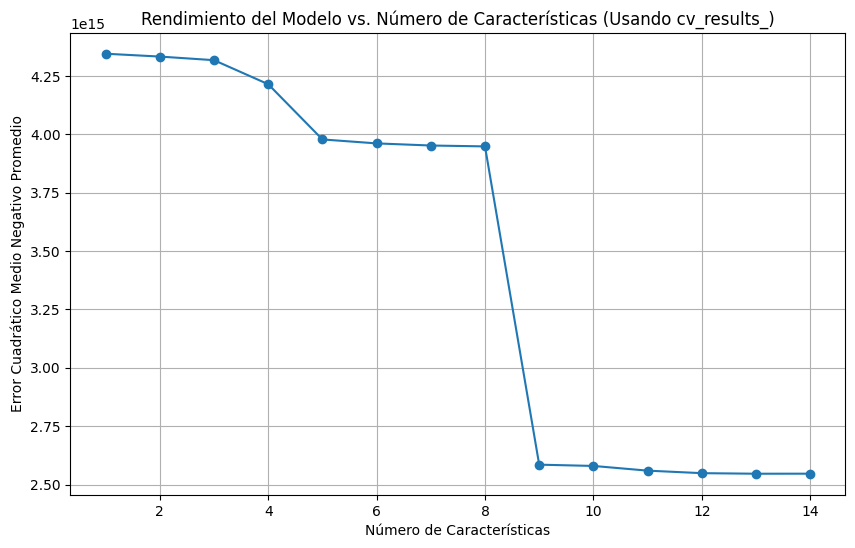

In [156]:
# Setting up cross validation with KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Creating the linear regression model
model = LinearRegression()

# Implementation of RFECV for automatic feature selection by cross-validation
selector_cv = RFECV(estimator=model, step=1, cv=kf, scoring='neg_mean_squared_error')
selector_cv.fit(X_train, y_train)

# Using 'cv_results_' to obtain the results of the RFECV model
mean_scores_cv_results_corrected = -selector_cv.cv_results_['mean_test_score']

# Plotting performance as a function of the number of features
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(mean_scores_cv_results_corrected) + 1), mean_scores_cv_results_corrected, marker='o')
plt.title('Rendimiento del Modelo vs. Número de Características (Usando cv_results_)')
plt.xlabel('Número de Características')
plt.ylabel('Error Cuadrático Medio Negativo Promedio')
plt.grid(True)
plt.show()



## Correlation_Matrix

In [157]:
# Calculating the correlation matrix between the characteristics and the target variable
correlation_matrix = movies_df.corr()

# Extracting the specific correlation with 'gross_adjusted'.
correlation_with_target = correlation_matrix['gross_adjusted'].drop('gross_adjusted')  # Excluding correlation with itself

# Sorting the characteristics by their absolute correlation to see the most significant ones.
sorted_correlation = correlation_with_target.abs().sort_values(ascending=False)

sorted_correlation



Adjusted_Revenue                           0.887477
Adjusted_Budget                            0.486151
Weighted_Rating_Adjusted_Revenue_Mean      0.398689
Weighted_Rating_Adjusted_Budget_Mean       0.367509
Weighted_Rating_Adjusted_Revenue_Median    0.343279
Weighted_Rating_Adjusted_Budget_Median     0.335574
Weighted_Rating_Actors                     0.263232
Weighted_Director                          0.244688
Average_Weighted_Rating                    0.233982
Weighted_Rating_Country                    0.233465
Weighted_Rating                            0.204894
Weighted_Rating_Companies                  0.204894
Average_Adjusted_Ratings                   0.202442
Weighted_Rating_Genre                      0.200220
Name: gross_adjusted, dtype: float64

In [158]:
l = list(sorted_correlation[:13].index)
l

['Adjusted_Revenue',
 'Adjusted_Budget',
 'Weighted_Rating_Adjusted_Revenue_Mean',
 'Weighted_Rating_Adjusted_Budget_Mean',
 'Weighted_Rating_Adjusted_Revenue_Median',
 'Weighted_Rating_Adjusted_Budget_Median',
 'Weighted_Rating_Actors',
 'Weighted_Director',
 'Average_Weighted_Rating',
 'Weighted_Rating_Country',
 'Weighted_Rating',
 'Weighted_Rating_Companies',
 'Average_Adjusted_Ratings']

## Prediction

## Random Forest

In [160]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# List of selected characteristics according to correlation, with confirmed column names
selected_features_list_corrected = [
    'Adjusted_Revenue', 'Adjusted_Budget', 'Weighted_Rating_Adjusted_Revenue_Mean',
    'Weighted_Rating_Adjusted_Budget_Mean', 'Weighted_Rating_Adjusted_Revenue_Median',
    'Weighted_Rating_Adjusted_Budget_Median', 'Weighted_Rating_Actors', 'Weighted_Director',
    'Weighted_Rating_Country', 'Average_Weighted_Rating', 'Weighted_Rating',
    'Weighted_Rating_Companies', 'Average_Adjusted_Ratings'
]

# Preparing the data again with the selected characteristics
X_selected_corrected = movies_df[selected_features_list_corrected]
y = movies_df['gross_adjusted']

# Again dividing the data into training and test sets.
X_train_selected_corrected, X_test_selected_corrected, y_train, y_test = train_test_split(
    X_selected_corrected, y, test_size=0.3, random_state=42
)

# Creating and training the Random Forest model with the correct column names
rf_model_corrected = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_corrected.fit(X_train_selected_corrected, y_train)

# Predicting in the test set
y_pred_corrected = rf_model_corrected.predict(X_test_selected_corrected)

# Evaluating the corrected model
mse_corrected = mean_squared_error(y_test, y_pred_corrected)
r2_corrected = r2_score(y_test, y_pred_corrected)

mse_corrected, r2_corrected


(3789901127016147.5, 0.7574812481486015)

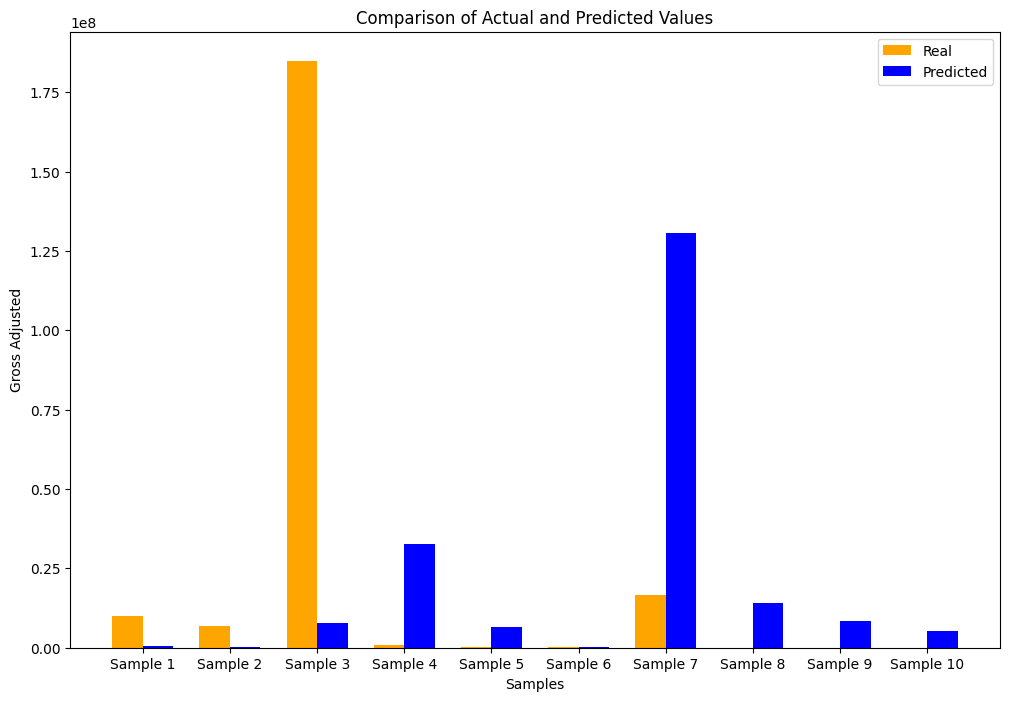

In [162]:
# Seed fixation for reproducibility
np.random.seed(42)

# Randomly select 10 indexes from the test set
random_indices = np.random.choice(X_test_selected_corrected.index, size=10, replace=False)

# Extract the actual values and predictions corresponding to these indexes.
actual_values = y_test.loc[random_indices]
predicted_values = y_pred_corrected[X_test_selected_corrected.index.isin(random_indices)]

# Create the bar chart
plt.figure(figsize=(12, 8))
bar_width = 0.35
index = np.arange(len(actual_values))

# Draw the bars for the actual and predicted values
plt.bar(index, actual_values, bar_width, color='orange', label='Real')
plt.bar(index + bar_width, predicted_values, bar_width, color='blue', label='Predicted')

# Configure chart labels and titles
plt.xlabel('Samples')
plt.ylabel('Gross Adjusted')
plt.title('Comparison of Actual and Predicted Values')
plt.xticks(index + bar_width / 2, [f'Sample {i+1}' for i in range(len(actual_values))])
plt.legend()

# Show the graph
plt.show()



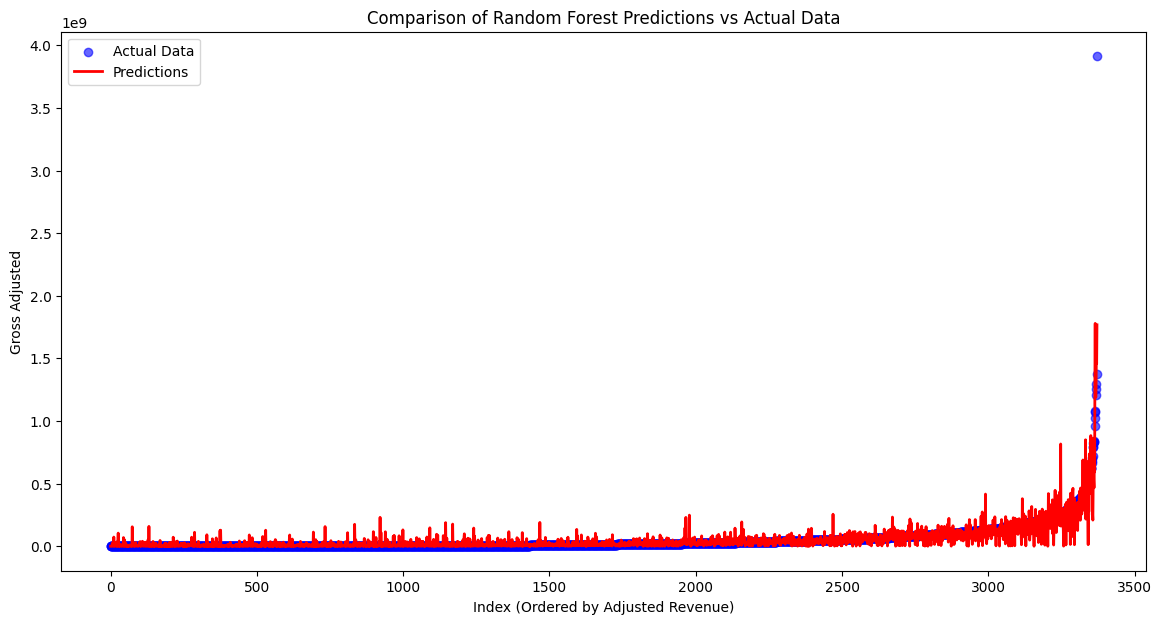

In [163]:
indices_ordered_by_actual = y_test.sort_values().index
actual_values_ordered = y_test.loc[indices_ordered_by_actual]
predicted_values_ordered = y_pred_corrected[np.argsort(y_test)]
# Creating the plot in English
plt.figure(figsize=(14, 7))
plt.scatter(range(len(actual_values_ordered)), actual_values_ordered, color='blue', label='Actual Data', alpha=0.6)
plt.plot(range(len(predicted_values_ordered)), predicted_values_ordered, color='red', label='Predictions', linewidth=2)
plt.title('Comparison of Random Forest Predictions vs Actual Data')
plt.xlabel('Index (Ordered by Adjusted Revenue)')
plt.ylabel('Gross Adjusted')
plt.legend()
plt.show()




## Neural network

In [164]:
df = movies_df
# List of selected features
selected_features_list_corrected = [
    'Adjusted_Revenue', 'Adjusted_Budget', 'Weighted_Rating_Adjusted_Revenue_Mean',
    'Weighted_Rating_Adjusted_Budget_Mean', 'Weighted_Rating_Adjusted_Revenue_Median',
    'Weighted_Rating_Adjusted_Budget_Median', 'Weighted_Rating_Actors', 'Weighted_Director',
    'Weighted_Rating_Country', 'Average_Weighted_Rating', 'Weighted_Rating',
    'Weighted_Rating_Companies', 'Average_Adjusted_Ratings'
]

# Separate the characteristics and the target variable
X = df[selected_features_list_corrected]
y = df['gross_adjusted']

# Apply a logarithmic transformation to the target variable to reduce the bias
y = np.log1p(y)

# Normalize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create the neural network model with improved regularization and dropout.
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_dim=X_train.shape[1], kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Compile the model with an adjusted learning rate in the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Use Early Stopping to avoid over-setting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training the model with more times and a tight batch size
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=1)

# Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_test)
print("Error cuadrático medio en el conjunto de prueba:", test_loss)


Epoch 1/100
225/225 [==============================] - 2s 6ms/step - loss: 56.2476 - val_loss: 8.6907
Epoch 2/100
225/225 [==============================] - 1s 4ms/step - loss: 11.3916 - val_loss: 6.2421
Epoch 3/100
225/225 [==============================] - 1s 3ms/step - loss: 9.9435 - val_loss: 5.9807
Epoch 4/100
225/225 [==============================] - 1s 3ms/step - loss: 9.1850 - val_loss: 5.6149
Epoch 5/100
225/225 [==============================] - 1s 3ms/step - loss: 8.4967 - val_loss: 5.4370
Epoch 6/100
225/225 [==============================] - 1s 3ms/step - loss: 8.0716 - val_loss: 5.5068
Epoch 7/100
225/225 [==============================] - 1s 3ms/step - loss: 7.7569 - val_loss: 5.2828
Epoch 8/100
225/225 [==============================] - 1s 3ms/step - loss: 7.7515 - val_loss: 5.4032
Epoch 9/100
225/225 [==============================] - 1s 3ms/step - loss: 7.2049 - val_loss: 5.1097
Epoch 10/100
225/225 [==============================] - 1s 3ms/step - loss: 6.9683 - val_

71/71 [==============================] - 0s 2ms/step


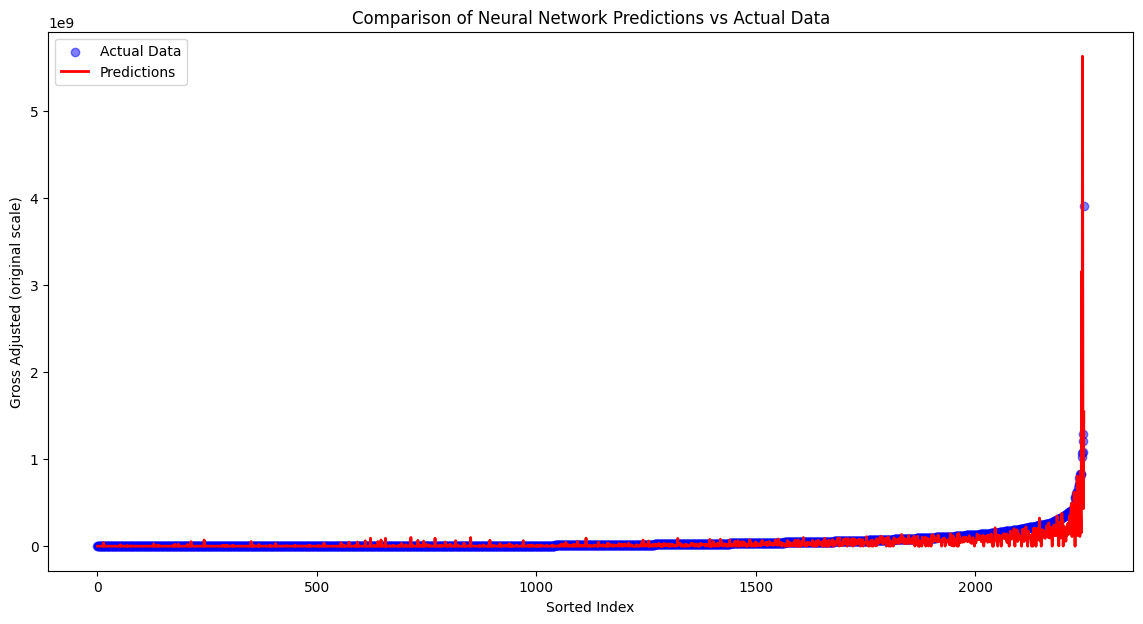

In [165]:
# Be sure to reset the indexes after the division and before any operation that depends on them.
y_test.reset_index(drop=True, inplace=True)
y_pred_nn = model.predict(X_test)
y_pred_nn = y_pred_nn.flatten()  # Flatten the predictions if they are in matrix form

# If you have logarithmically transformed y_test, remember to reverse that for the predictions as well.
y_test_original = np.expm1(y_test)
y_pred_original = np.expm1(y_pred_nn)

# Sort the values by y_test_original for a consistent display
order = np.argsort(y_test_original)
sorted_y_test = y_test_original[order]
sorted_y_pred = y_pred_original[order]

# Creating the chart
plt.figure(figsize=(14, 7))
plt.scatter(range(len(sorted_y_test)), sorted_y_test, color='blue', label='Actual Data', alpha=0.5)
plt.plot(range(len(sorted_y_pred)), sorted_y_pred, color='red', label='Predictions', linewidth=2)
plt.title('Comparison of Neural Network Predictions vs Actual Data')
plt.xlabel('Sorted Index')
plt.ylabel('Gross Adjusted (original scale)')
plt.legend()
plt.show()


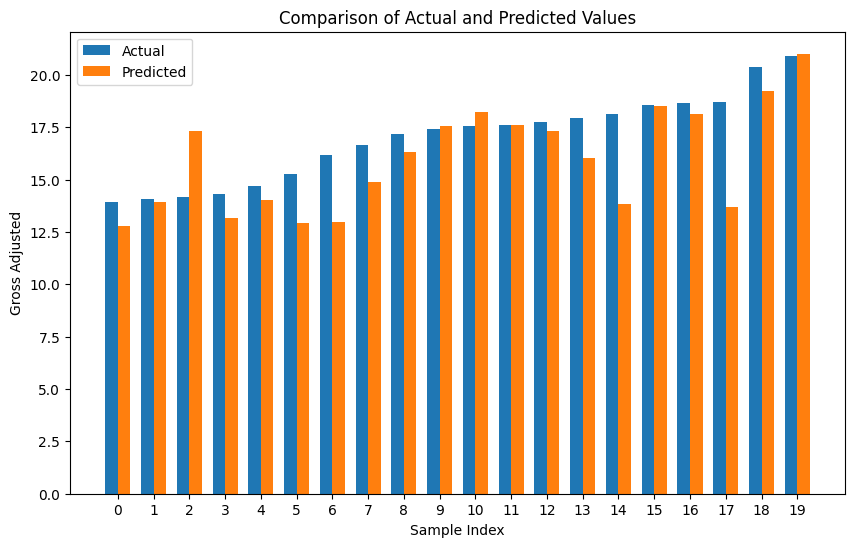

In [166]:
# Select a small subset for display
num_samples = 20
indices = np.random.choice(y_test.index, num_samples, replace=False)
sampled_y_test = y_test.loc[indices]
sampled_y_pred = y_pred_nn[indices]

# Sort by the actual values for a clearer visualization
order = np.argsort(sampled_y_test)
sorted_sampled_y_test = sampled_y_test.iloc[order]
sorted_sampled_y_pred = sampled_y_pred[order]

# Create the bar chart
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(num_samples)

plt.bar(index, sorted_sampled_y_test, bar_width, label='Actual')
plt.bar(index + bar_width, sorted_sampled_y_pred, bar_width, label='Predicted')

plt.xlabel('Sample Index')
plt.ylabel('Gross Adjusted')
plt.title('Comparison of Actual and Predicted Values')
plt.xticks(index + bar_width / 2, index)
plt.legend()

plt.show()
